In [8]:
from torch import nn
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import torch.optim as optim
import torchvision
import numpy as np
import json
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import glob
import cv2
from torchsummary import summary
import copy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

<h3>Helper Functions</h3>

In [5]:
def showImage(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def showImageRow(images, title=None):
    plt.figure(figsize=(17, 15))
    if title is not None:
        plt.title(title)
    for i, image in enumerate(images, 1):
        plt.subplot(1, 5, i)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [6]:
JSON_PATH = os.path.join("dataset", "annotation-small.json")
IMAGE_PATH = os.path.join("dataset", "images/")
LABEL_PATH = os.path.join("dataset", "labels")
ROWS, COLS = (256, 256)
EXT_JPG = "*.jpg"

<h1>Dataset preperation </h1>

In [7]:
annotation_data = None

with open(JSON_PATH, "r") as f: 
    annotation_data = json.load(f)


In [9]:
image_paths = glob.glob(os.path.join(IMAGE_PATH, EXT_JPG))[:1000]
label_paths = glob.glob(os.path.join(LABEL_PATH, EXT_JPG))[:1000]

x_train_paths, x_test_paths, y_train_paths, y_test_paths = train_test_split(image_paths, label_paths, test_size=0.2)

print("Length of Training Data:", len(x_train_paths))
print("Length of Testing  Data:", len(x_test_paths))

Length of Training Data: 800
Length of Testing  Data: 200


In [17]:
class BuildingDataset(Dataset): 
    def __init__(self, image_paths, label_paths, image_transforms=None, label_transforms=None): 
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, i):
        image_path, label_path = self.image_paths[i], self.label_paths[i] 
        image = imread(image_path)
        label = imread(label_path)

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.label_transforms: 
            label = self.label_transforms(label)

        return image, label

In [18]:
data_transforms = {
    "image": transforms.Compose([transforms.ToTensor(), transforms.Resize((ROWS, COLS))]),
    "label": transforms.Compose([transforms.ToTensor(), transforms.Resize((ROWS, COLS))]),
}

# train_split = 1000

BATCH_SIZE = 8

task3_datasets = {
    "train": BuildingDataset(
        x_train_paths,
        y_train_paths,
        data_transforms["image"],
        data_transforms["label"],
    ),
    "val": BuildingDataset(
        x_test_paths,
        y_test_paths,
        data_transforms["image"],
        data_transforms["label"],
    ),
}


dataloaders = {
    phase: DataLoader(task3_datasets[phase], BATCH_SIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}



<h1>Unet ResNet model</h1>

In [19]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
            Paramaters for Deconvolution were chosen to avoid artifacts, following
            link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(
                    middle_channels, out_channels, kernel_size=4, stride=2, padding=1
                ),
                nn.ReLU(inplace=True),
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear"),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNetResNet(nn.Module):
    """PyTorch U-Net model using ResNet(34, 101 or 152) encoder.

    UNet: https://arxiv.org/abs/1505.04597
    ResNet: https://arxiv.org/abs/1512.03385
    Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

    Args:
            encoder_depth (int): Depth of a ResNet encoder (34, 101 or 152).
            num_classes (int): Number of output classes.
            num_filters (int, optional): Number of filters in the last layer of decoder. Defaults to 32.
            dropout_2d (float, optional): Probability factor of dropout layer before output layer. Defaults to 0.2.
            pretrained (bool, optional):
                False - no pre-trained weights are being used.
                True  - ResNet encoder is pre-trained on ImageNet.
                Defaults to False.
            is_deconv (bool, optional):
                False: bilinear interpolation is used in decoder.
                True: deconvolution is used in decoder.
                Defaults to False.

    """

    def __init__(
        self,
        encoder_depth,
        num_classes,
        num_filters=32,
        dropout_2d=0.2,
        pretrained=False,
        is_deconv=False,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d = dropout_2d

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError(
                "only 34, 101, 152 version of Resnet are implemented"
            )

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(
            self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.pool
        )

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(
            bottom_channel_nr, num_filters * 8 * 2, num_filters * 8, is_deconv
        )
        self.dec5 = DecoderBlockV2(
            bottom_channel_nr + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec4 = DecoderBlockV2(
            bottom_channel_nr // 2 + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec3 = DecoderBlockV2(
            bottom_channel_nr // 4 + num_filters * 8,
            num_filters * 4 * 2,
            num_filters * 2,
            is_deconv,
        )
        self.dec2 = DecoderBlockV2(
            bottom_channel_nr // 8 + num_filters * 2,
            num_filters * 2 * 2,
            num_filters * 2 * 2,
            is_deconv,
        )
        self.dec1 = DecoderBlockV2(
            num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv
        )
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        pool = self.pool(conv5)
        center = self.center(pool)

        dec5 = self.dec5(torch.cat([center, conv5], 1))


        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        return self.final(F.dropout2d(dec0, p=self.dropout_2d))


# Training Pipline


In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    val_loss_history = []
    train_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch} / {num_epochs - 1}", end="\t")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            running_loss = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} loss: {epoch_loss:.4f}", end="\t")

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, os.path.join("weights", "best.pt"))

            if phase == "val":
                val_loss_history.append(epoch_loss)
                last_model_wts = copy.deepcopy(model.state_dict())
                torch.save(last_model_wts, os.path.join("weights", "last.pt"))

            if phase == "train":
                train_loss_history.append(epoch_loss)

        print()

    print("-" * 30)
    print(f"Training Complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    return val_loss_history, train_loss_history


In [20]:
model = UNetResNet(34, 1, pretrained=True, is_deconv=True).to(device=device)


In [11]:
def diceLoss(pred, target, smooth=1):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = (pred**2).sum() + (target**2).sum()
    loss = 1 - ((2.0 * intersection + smooth) / (union + smooth))
    return loss


def weighted_loss(pred, target, bce_weight=0.5):
    bce = nn.functional.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = diceLoss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss


In [12]:
EPOCHS = 10
LEARNING_RATE = 0.0001


In [18]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [13]:
criterion = weighted_loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:

val_loss_history, train_loss_history = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=EPOCHS
)


<h1>Testing Pipeline</h1>

In [14]:
data_transforms = {
    "image": transforms.Compose([transforms.ToTensor(), transforms.Resize((ROWS, COLS))]),
    "label": transforms.Compose([transforms.ToTensor(), transforms.Resize((ROWS, COLS))]),
}

In [17]:
weights = torch.load("weights/best.pt")

In [36]:
def threshold(image, thres=0.5):
    image[image > thres] = 1
    image[image <= thres] = 0
    return image

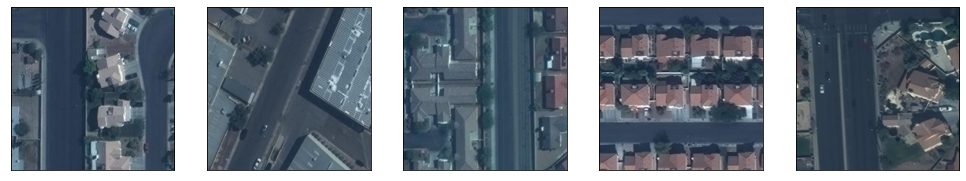

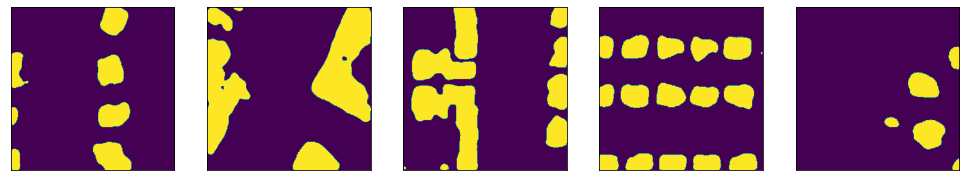

In [37]:
# Your testing pipeline
model.load_state_dict(weights)
model.eval()

test_paths = list(glob.glob("dataset/images/*.jpg"))[-5:]
label_paths = list(glob.glob("dataset/labels/*.jpg"))[-5:]

outputs = []
inputs = []

for image_path, label_path in zip(test_paths, label_paths):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    inputs.append(cv2.resize(image, (ROWS, COLS)))
    # image = torch.tensor(cv2.resize(image, (ROWS, COLS))).to(device=device)
    image = data_transforms["image"](image).to(device=device)
    image = image.reshape(1, *image.shape)
    output = model(image)[0].permute(1, 2, 0).detach().cpu().numpy()
    
    outputs.append(threshold(output))

showImageRow(inputs)
showImageRow(outputs)
